##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [ ]:
#%pip install pandas
#%pip install matplotlib
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and
##### have the .csv file inside that. A relative path *must* be used when loading data into pandas

In [ ]:
# Can have as many cells as you want for code
import pandas as pd
filepath = "./data/catA_train.csv"
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

In [1]:
# for self testing only
import pandas as pd
filepath = "catA_train.csv"

### **ALL** Code for machine learning and dataset analysis should be entered below.
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.


# **1. Data preparation/preprocessing**

In [2]:
#import data
df1 = pd.read_csv(filepath)

In [3]:
# find the number of rows and columns in our dataset
print(df1.shape)

# find the names of columns in our dataset
print(df1.columns)

(29182, 28)
Index(['LATITUDE', 'LONGITUDE', 'AccountID', 'Company', 'SIC Code', 'Industry',
       '8-Digit SIC Code', '8-Digit SIC Description', 'Year Found',
       'Entity Type', 'Parent Company', 'Parent Country', 'Ownership Type',
       'Company Description', 'Square Footage',
       'Company Status (Active/Inactive)', 'Employees (Single Site)',
       'Employees (Domestic Ultimate Total)',
       'Employees (Global Ultimate Total)',
       'Sales (Domestic Ultimate Total USD)',
       'Sales (Global Ultimate Total USD)', 'Import/Export Status',
       'Fiscal Year End', 'Global Ultimate Company', 'Global Ultimate Country',
       'Domestic Ultimate Company', 'Is Domestic Ultimate',
       'Is Global Ultimate'],
      dtype='object')


In [4]:
# check for the number of missing values in the dataframe
df1.isna().sum()

LATITUDE                                 120
LONGITUDE                                120
AccountID                                  0
Company                                    0
SIC Code                                   0
Industry                                   0
8-Digit SIC Code                           0
8-Digit SIC Description                    0
Year Found                               434
Entity Type                                0
Parent Company                           514
Parent Country                           520
Ownership Type                             0
Company Description                        0
Square Footage                         29182
Company Status (Active/Inactive)           0
Employees (Single Site)                12403
Employees (Domestic Ultimate Total)       79
Employees (Global Ultimate Total)       2774
Sales (Domestic Ultimate Total USD)        0
Sales (Global Ultimate Total USD)          0
Import/Export Status                   22569
Fiscal Yea

## 1.1 Dealing with Missing Data



*   *Remove*

    As indicated by the feature ranking results (Section 2.2.1), both "Latitude" and "Longitude" are important features. Considering its substantial potential impact on sales, rows with missing "Latitude" and "Longitude" values should, in our perspective, be excluded from the modelling process. Additionally, the number of missing values of these two features (120) is negligible in contrast to the substantial total sample size (29,182). Consequently, we find it appropriate to address this by simply removing rows with missing "Latitude" or "Longitude" values.





In [5]:
df2 = df1.dropna(subset=["LATITUDE", "LONGITUDE"])



*   *Impute with Domain Knowledge*

    Nevertheless, features like "Employees (Single Site)" do have a significant number of missing values. Simply discarding these features with missing values might result in information loss, and thus distort the original characteristics of the data. This might lead to a loss of potentially meaningful patterns or insights that could have been derived from those missing data points, adversely affecting our modeling process. Therefore, we decided to delve into the dataset and identify potential patterns that could assist in imputing such missing values, complemented by our domain knowledge.





In [8]:
# Analysis

df_testing = df2.dropna(subset=["Employees (Single Site)", "Employees (Domestic Ultimate Total)"])

# When the company is its domestic ultimate company
df_testing = df_testing[df2['Is Domestic Ultimate'] == 1]

# Data with employees(single site) being equal to employees(domestic ultimate total)
df_testing1 = df_testing[df_testing['Employees (Single Site)'] == df_testing['Employees (Domestic Ultimate Total)']]

print(df_testing1.shape)


(4977, 28)


C:\Users\hucan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [9]:
# Data with employees(single site) not being equal to employees(domestic ultimate total)
df_testing2 = df_testing[df_testing['Employees (Single Site)'] != df_testing['Employees (Domestic Ultimate Total)']]

print(df_testing2.shape)

(200, 28)


  This demonstrates that, when the company is its domestic ultimate company, "Employees(Single Site)" would be most likely equal to "Employees(Domestic Ultimate Total)".

  This can be explained with domain knowledge. "Employees(Domestic Ultimate Total)" is defined as the employees for the domestic Ultimate parent entities while "Employees(Single Site)" is defined as the number of employees at a single location. When the company is the domestic ultimate company, its employee count, "Employees(Single Site)", would include employees from all of its subsidiaries and thus be equal to "Employees(Domestic Ultimate Total)".

In [11]:
# Impute the missing data
condition_mask = df2['Is Domestic Ultimate'] == 1
df2.loc[condition_mask, 'Employees (Single Site)'] = df2.loc[condition_mask, 'Employees (Single Site)'].fillna(df2.loc[condition_mask, 'Employees (Domestic Ultimate Total)'])
df2 = df2.dropna(subset=['Employees (Single Site)'])




*   *KNN Imputation*

    The K-Nearest Neighbors (KNN) imputer is well-suited for imputing missing values in our dataset due to its localized imputation approach, which considers neighboring data points to estimate missing values. Unlike global imputation methods, KNN adapts to the distribution of the data and can handle both numerical and categorical features, making it versatile. This applies to our dataset with both numerical and categorical features. It is particularly effective in our dataset where relationships between variables are non-linear, and there is no assumption of normality in the data. The parameter tuning feature allows flexibility in choosing the number of neighbors, and it aims to preserve local relationships, making it suitable for datasets with non-random patterns of missing values. As detailed in the subsequent evaluation section, the choice of k = 5 yields the most effective imputation results and is thus selected.




In [ ]:
# See code under Section 3

## 1.2 Data encoding



*   *Encode SIC (Label Encoder)*

Upon evaluation with various metrics and comparing the respective R-squared values with threshold = [7,14], threshold = 11 generated the largest R-squared score and is used for encoding.


In [12]:
sic_code_frequency = df2['SIC Code'].value_counts()
threshold = 11
low_frequency_sic_codes = sic_code_frequency[sic_code_frequency < threshold].index
df2['SIC Code'] = df2['SIC Code'].replace(low_frequency_sic_codes, 'Others')
df2['SIC Code'] = df2['SIC Code'].astype(str)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df2['SIC Code'] = label_encoder.fit_transform(df2['SIC Code'])



*   *Encode "Entity Type"*

    We attempted both One-Hot Encoding and Label Encoder for "Entity Type". However, during the Feature Ranking analysis (Section 2.2.1), "Entity Type" is proven to be a less important feature. Upon testing the models, we realised that despite being encoded, "Entity Type" would only adversely affect our model performance. Thus, we decided to exclude "Entity Type".




In [13]:
# Analysis
entity_type_counts = df2['Entity Type'].value_counts()
print(entity_type_counts)

Subsidiary     18271
Parent          7485
Independent      260
Branch            10
Name: Entity Type, dtype: int64


In [14]:
df2['Entity Type'] = label_encoder.fit_transform(df2['Entity Type'])

# **2. EDA**

## 2.1 Feature Engineering

### 2.1.1 Data Type Conversion

It is essential to convert feature with originally integer values to boolean form so that models can handle the data.

In [15]:
# Convert 1/0 to TRUE/FALSE
df2['Is Domestic Ultimate'] = df2['Is Domestic Ultimate'] == 1
df2['Is Global Ultimate'] = df2['Is Global Ultimate'] == 1

### 2.1.2 Data Cleaning (only keep ownership == private)

In [16]:
# Analysis
ownership_type_counts = df2['Ownership Type'].value_counts()
print(ownership_type_counts)

Private           25294
Public              639
Partnership          45
Public Sector        35
Non-Corporates        9
Nonprofit             4
Name: Ownership Type, dtype: int64


This shows that the majority of companies are privately owned. Thus, we decided to only keep such companies and drop the rest.

In [17]:
# Clean Ownership Type
df2 = df2.drop(df2[df2['Ownership Type'] != "Private"].index)

### 2.1.3 Create Artificial Features (imports/exports)

In [18]:
# Analysis
imports_exports_counts = df2['Import/Export Status'].value_counts()
print(imports_exports_counts)

Both Imports & Exports    3676
Exports                   1398
Imports                    575
Name: Import/Export Status, dtype: int64


In [19]:
# Create new feature
df2['Import/Export Status_Missing'] = df2['Import/Export Status'].isna()

Instead of having 4 categories for "Import/Export Status", we created a new feautre called "Import/Export Status_Missing". The column contains boolan value 1 (Import/Export Status Missing) and 0 (Import/Export Status Not Missing).



*   *Insights*



Upon examining the "Import/Export Status" variable, 22,569 missing values were identified out of a total of 29,182 entries. A more in-depth examination of the missing values revealed that 7,527 companies were associated with the SIC code 6719, constituting approximately one-third of the entire dataset with missing "Import/Export Status".

Closer inspection of the SIC code 6719 revealed that these 7,527 companies primarily function as holding companies, implying that they do not directly engage in daily import and export activities; instead, they derive profits through the acquisition or control of ownership interests in other companies.


## 2.2 Feature Selection

*   *Drop non-numeric features*

In [20]:
columns_to_drop = ['Ownership Type', "Company Status (Active/Inactive)",'Import/Export Status',"error", "Fiscal Year End", "Global Ultimate Company", "Domestic Ultimate Company", "Web Address", "Square Footage", "Company Description", "PostCode", "8-Digit SIC Code", "8-Digit SIC Description", "AccountID",
                   "Parent Company", "City", "Country", "Address", "Address1", "Industry", "Region", "Parent Country", "Global Ultimate Country", "Company"]
df3 = df2.drop(columns=[col for col in columns_to_drop if col in df2.columns], errors='ignore')

###  2.2.1 Feature Ranking



*   *Correlation Matrix*




In [21]:
correlation_matrix = df3.corr()
correlation_df = pd.DataFrame(correlation_matrix)
correlation_df

,LATITUDE,LONGITUDE,SIC Code,Year Found,Entity Type,Employees (Single Site),Employees (Domestic Ultimate Total),Employees (Global Ultimate Total),Sales (Domestic Ultimate Total USD),Sales (Global Ultimate Total USD),Is Domestic Ultimate,Is Global Ultimate,Import/Export Status_Missing
LATITUDE,1.000000,-0.052074,-0.100352,-0.030425,0.044921,-0.007398,0.000716,-0.010651,0.001088,-0.012212,-0.002388,-0.040653,-0.060088
LONGITUDE,-0.052074,1.000000,0.023178,-0.004713,-0.009282,-0.006453,0.013087,0.003886,-0.002667,0.010639,0.005324,0.010534,0.005264
SIC Code,-0.100352,0.023178,1.000000,0.138244,-0.098095,-0.053952,-0.005258,0.000225,-0.024286,-0.023032,0.021222,0.102456,0.201199
Year Found,-0.030425,-0.004713,0.138244,1.000000,-0.132017,-0.099019,-0.043976,-0.031161,0.015138,-0.027929,0.072404,0.133644,0.382889
Entity Type,0.044921,-0.009282,-0.098095,-0.132017,1.000000,0.030848,0.032088,0.068112,0.040565,0.086399,-0.477778,-0.902415,-0.100135
Employees (Single Site),-0.007398,-0.006453,-0.053952,-0.099019,0.030848,1.000000,0.180851,0.055020,0.010735,0.050504,0.023870,-0.038646,-0.096497
Employees (Domestic Ultimate Total),0.000716,0.013087,-0.005258,-0.043976,0.032088,0.180851,1.000000,0.023605,0.020877,0.029307,-0.067274,-0.053277,-0.020556
Employees (Global Ultimate Total),-0.010651,0.003886,0.000225,-0.031161,0.068112,0.055020,0.023605,1.000000,-0.001670,0.662706,0.077462,-0.094783,-0.057078
Sales (Domestic Ultimate Total USD),0.001088,-0.002667,-0.024286,0.015138,0.040565,0.010735,0.020877,-0.001670,1.000000,0.110911,-0.055581,-0.042075,0.005048
Sales (Global Ultimate Total USD),-0.012212,0.010639,-0.023032,-0.027929,0.086399,0.050504,0.029307,0.662706,0.110911,1.000000,0.035446,-0.103053,-0.039522


*   *Heap Map*


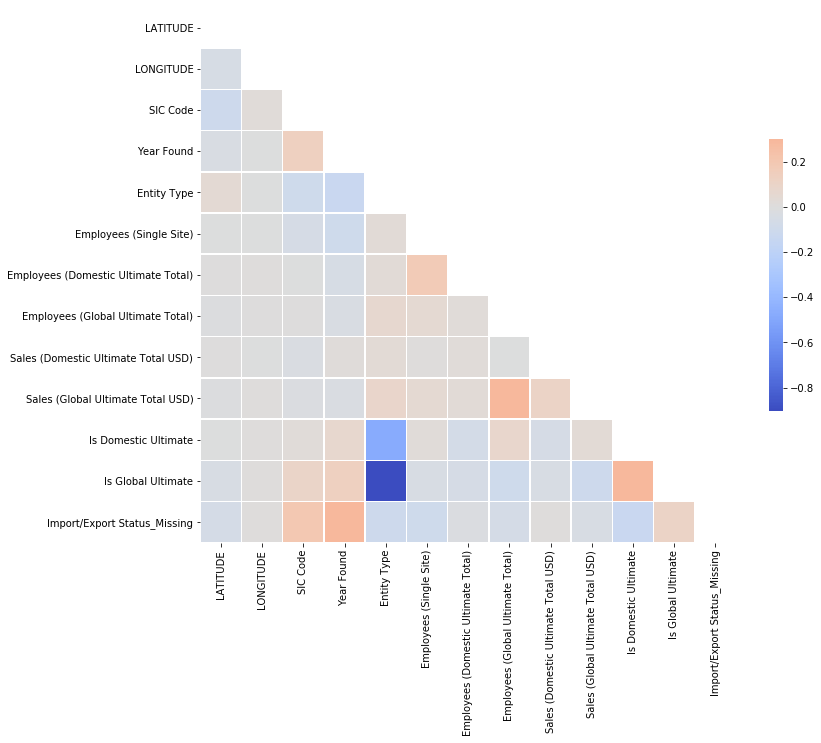

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate the correlation matrix
corr_matrix = df3.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio, using "coolwarm" colormap
sns.heatmap(corr_matrix, mask=mask, cmap="coolwarm", vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

From the correlation table and heat map, we cannot observe significant correlation between domestic sales and certain features as it shows an even distribution of correlation across factors. Hence, we decided to implement another two methods.



*   *Random Forest Regressor*




Random Forest is an ensemble learning method that consists multiple decision trees. Each decision tree is constructed using a subset of the data and a subset of features at each split. It aims to maximize the reduction in impurity at each split. As a result, features that are selected at the top of the trees are in general more important than features that are selected at the end nodes of the trees, as the top splits generally lead to larger information gains.


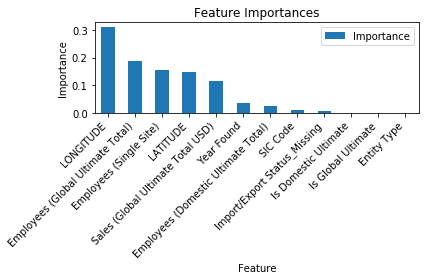

In [23]:
# Train test split
from sklearn.model_selection import train_test_split

X = df3.drop('Sales (Domestic Ultimate Total USD)', axis=1)
y = df3['Sales (Domestic Ultimate Total USD)']
columns_name = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# KNN Imputer
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors = 5)

X_train = imputer.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = columns_name)

X_test = imputer.transform(X_test)
X_test = pd.DataFrame(X_test, columns = columns_name)

############################################
# Feature ranking with RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

forest = RandomForestRegressor(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)
importances = forest.feature_importances_

# Create a DataFrame with feature names and importances, sorted by importance in descending order
X = pd.DataFrame(X, columns = df3.columns)
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
fig, ax = plt.subplots()
feature_importance_df.plot.bar(x='Feature', y='Importance', ax=ax)
ax.set_title("Feature Importances")
ax.set_ylabel("Importance")
ax.set_xticklabels(feature_importance_df['Feature'], rotation=45, ha='right')
fig.tight_layout()

plt.show()

From the results, we can see that "Longitude", "Employees (Domestic Ultimate Total)", "Latitude" and "Employees (Single Site)" are the more significant factors.




* *RFE*



The estimator is initially trained using the given set of features, and the importance of each feature is determined either through a specific attribute or a callable function. Subsequently, the least important features are iteratively removed from the current set, and this process is repeated recursively on the pruned set until the desired number of features to be selected is achieved. The ranking assigned to each feature represents its relative importance in contributing to the model's performance. The support indicates whether a feature is considered important or not based on a specified threshold. If the support is True for a feature, it means the feature is considered important. If the support is False for a feature, it means the feature is deemed less important and may be excluded.

In [24]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification

estimator = RandomForestRegressor(n_estimators=100, random_state=42)
rfe = RFE(estimator, n_features_to_select=5)
rfe.fit(X_train, y_train)

feature_ranking = rfe.ranking_
feature_support = rfe.support_

# Create a DataFrame with feature names, ranking, and support, sorted by ranking in ascending order
feature_info_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Ranking': feature_ranking,
    'Support': feature_support
})

feature_info_df = feature_info_df.sort_values(by='Ranking')

print(feature_info_df)

                                Feature  Ranking  Support
0                              LATITUDE        1     True
1                             LONGITUDE        1     True
3                            Year Found        1     True
7     Employees (Global Ultimate Total)        1     True
8     Sales (Global Ultimate Total USD)        1     True
5               Employees (Single Site)        2    False
6   Employees (Domestic Ultimate Total)        3    False
2                              SIC Code        4    False
11         Import/Export Status_Missing        5    False
9                  Is Domestic Ultimate        6    False
10                   Is Global Ultimate        7    False
4                           Entity Type        8    False


From the result, we can see that "Latitude", "Longitude", "Year Found", and "Employees (Global Ultimate Total)" are considered significant features with True support.


From both feature ranking methods, "Latitude", "Longitude", "Employees (Global Ultimate Total)" and "Employees (Single Site)" can be considered significant. Since location is the top ranking feature, we choose to implement "dropna" on longitude and latitude as imputation may create noise.

**Drop unimportant features**

In [25]:
df3 = df3.drop(columns=['Entity Type'])

From Random Forest regressor, as well as RFE, we can see that Entity Type is always ranked last. Therefore, although we tried to encode this feature, it still does not play an important role in our model. Consequently, we decided to drop this variable.


### 2.2.2 Variance Analysis

Variance Threshold is an important apporach for feature selection as it removes all features with low variance. The reason is that features (independent variables) with low variance cannot explain much of the dependent variable which is the Domestic Ultimate Sales in our scenario.

In [26]:
import pandas as pd
numerical_columns = df3[["LATITUDE","LONGITUDE","SIC Code","Year Found","Employees (Single Site)","Employees (Domestic Ultimate Total)","Employees (Global Ultimate Total)",
                         "Sales (Domestic Ultimate Total USD)","Sales (Global Ultimate Total USD)"]]
#different threshold, number of features kept
from sklearn.feature_selection import VarianceThreshold
thresholds = [0.01, 0.1, 1, 10]  # Experiment with different thresholds

for threshold in thresholds:
    sel = VarianceThreshold(threshold=threshold)
    X_selected = sel.fit_transform(numerical_columns)
    print(f"Number of features kept with threshold {threshold}: {X_selected.shape[1]}")

Number of features kept with threshold 0.01: 7
Number of features kept with threshold 0.1: 7
Number of features kept with threshold 1: 7
Number of features kept with threshold 10: 7


As evident from the results, only 2 out of 9 numerical variables are considered low-variance variables. Therefore, it is advisable to remove them. To gain a deeper understanding, we reexamined these two variables.

In [27]:
variance=numerical_columns.var()
print(variance)

LATITUDE                               1.927556e-03
LONGITUDE                              2.890853e-03
SIC Code                               4.168536e+03
Year Found                             1.639341e+02
Employees (Single Site)                3.031563e+04
Employees (Domestic Ultimate Total)    1.018032e+06
Employees (Global Ultimate Total)      2.242970e+09
Sales (Domestic Ultimate Total USD)    7.129202e+19
Sales (Global Ultimate Total USD)      5.110233e+20
dtype: float64


The code in the above cell displays the variance across all numerical variables. The VarianceThreshold approach suggests removing latitude and longitude due to their low variance. However, a more nuanced examination reveals a different perspective. Firstly, the data belongs to Singapore, where lattitude and longitude values exibit a highly limited range and are comparatively smaller than other varibles like sales. Additionally, according to our feature ranking, they are important features with longitude ranked 1st and latitude ranked 3rd, which will be illustrated later.

In summary, despite the initial consideration to remove certain variables, we recommend retaining all the numerical variables for further analysis.

# **3. Modelling & Model Evaluation**

* *Train Test Split*

In [28]:
from sklearn.model_selection import train_test_split

X = df3.drop('Sales (Domestic Ultimate Total USD)', axis=1)
y = df3['Sales (Domestic Ultimate Total USD)']
columns_name = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

* *KNN Imputer*

In [29]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors = 5)

X_train = imputer.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = columns_name)

X_test = imputer.transform(X_test)
X_test = pd.DataFrame(X_test, columns = columns_name)

Instead of resorting to conventional practices such as dropping all missing values or replacing them with zero or median, we implemented KNN imputers to replace input’s NA value with the most likely number based on the non-missing observation within a specific column. By doing so, we can make the model more representable and accurate in predicting the dependent variable. Why did we choose k=5 in particular?


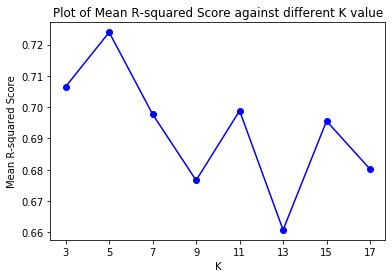

In [30]:
import matplotlib.pyplot as plt

# Data
x_values = [3, 5, 7, 9, 11, 13, 15, 17]
y_values = [0.70655, 0.72394, 0.69773, 0.67660, 0.69885, 0.66076, 0.69555, 0.68019]

# Plotting
plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')

# Adding labels and title
plt.xlabel('K')
plt.ylabel('Mean R-squared Score')
plt.title('Plot of Mean R-squared Score against different K value')
plt.xticks([3, 5, 7, 9, 11, 13, 15, 17])
# Show the plot
plt.show()

 Our experiment with different K values revealed that the R-Squared value was the highest when K is equal to 5. This suggests that five nearest neighbors align well with the underlying pattern of the dataset.




## 3.1 Gradient Boosting Regression




In [31]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

# Create and fit a gradient boosting regressor
gradient_model = GradientBoostingRegressor(random_state=42)
gradient_model.fit(X_train, y_train)

# K-fold cross validation with various evaluation metrics
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(gradient_model, X_train, y_train, cv=kf, scoring='r2')

# R-squared values
print("Cross-Validation R-squared scores:", cv_scores)
print("Mean R-squared score:", cv_scores.mean())
print("Standard Deviation of R-squared scores:", cv_scores.std())

# Mean adjusted R-squared value
n = len(X_train)
p = X_test.shape[1]
adjusted_r2 = 1 - ((1 - cv_scores.mean()) * (n - 1) / (n - p - 1))
print("Mean adjusted R-squared score:", adjusted_r2)

# MSE
cv_mse_scores = -cross_val_score(gradient_model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
mean_cv_mse = np.mean(cv_mse_scores)
print("Cross-validated Mean Squared Error:", mean_cv_mse)

# AIC
num_samples = len(y)
num_parameters = len(gradient_model.get_params())
aic = 2 * num_parameters + num_samples * np.log(mean_cv_mse)
print("AIC:", aic)

# BIC
bic = num_samples * np.log(mean_cv_mse) + num_parameters * np.log(num_samples)
print("BIC:", bic)

Cross-Validation R-squared scores: [0.56406816 0.87910863 0.81092537 0.61903439 0.75557404 0.87357622
 0.78716806 0.95916849 0.12984129 0.8610102 ]
Mean R-squared score: 0.7239474838165942
Standard Deviation of R-squared scores: 0.22862007901947906
Mean adjusted R-squared score: 0.7237973291571462
Cross-validated Mean Squared Error: 1.978274822339959e+19
AIC: 1123888.3627759207
BIC: 1124059.267548262




## 3.2 Random Forest Regressor




In [32]:
from sklearn.ensemble import RandomForestRegressor

# Create and fit the random forest regressor
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)

# K-fold cross validation with various evaluation metrics
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(random_forest_model, X_train, y_train, cv=kf, scoring='r2')

# R-squared values
print("Cross-Validation R-squared scores:", cv_scores)
print("Mean R-squared score:", cv_scores.mean())
print("Standard Deviation of R-squared scores:", cv_scores.std())

# Mean adjusted R-squared value
n = len(X_train)
p = X_test.shape[1]
adjusted_r2 = 1 - ((1 - cv_scores.mean()) * (n - 1) / (n - p - 1))
print("Mean adjusted R-squared score:", adjusted_r2)

# MSE
cv_mse_scores = -cross_val_score(random_forest_model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
mean_cv_mse = np.mean(cv_mse_scores)
print("Cross-validated Mean Squared Error:", mean_cv_mse)

# AIC
num_samples = len(y)
num_parameters = len(random_forest_model.get_params())
aic = 2 * num_parameters + num_samples * np.log(mean_cv_mse)
print("AIC:", aic)

# BIC
bic = num_samples * np.log(mean_cv_mse) + num_parameters * np.log(num_samples)
print("BIC:", bic)

Cross-Validation R-squared scores: [ 0.58310281  0.94069033  0.75952341  0.72879428  0.28502391  0.89786702
  0.50770878  0.92222534 -0.01677884  0.89718413]
Mean R-squared score: 0.6505341181038108
Standard Deviation of R-squared scores: 0.3003115402674663
Mean adjusted R-squared score: 0.6503440313362265
Cross-validated Mean Squared Error: 2.070029395636686e+19
AIC: 1125027.1331663567
BIC: 1125165.4846487283




## 3.3 Linear Regression




In [33]:
from sklearn.linear_model import LinearRegression

# Create and fit the linear regression model
linear_model = LinearRegression ()
linear_model.fit(X_train, y_train)

# K-fold cross validation with various evaluation metrics
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(linear_model, X_train, y_train, cv=kf, scoring='r2')

# R-squared values
print("Cross-Validation R-squared scores:", cv_scores)
print("Mean R-squared score:", cv_scores.mean())
print("Standard Deviation of R-squared scores:", cv_scores.std())

# Mean adjusted R-squared value
n = len(X_train)
p = X_test.shape[1]
adjusted_r2 = 1 - ((1 - cv_scores.mean()) * (n - 1) / (n - p - 1))
print("Mean adjusted R-squared score:", adjusted_r2)

# MSE
cv_mse_scores = -cross_val_score(linear_model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
mean_cv_mse = np.mean(cv_mse_scores)
print("Cross-validated Mean Squared Error:", mean_cv_mse)

# AIC
num_samples = len(y)
num_parameters = len(linear_model.get_params())
aic = 2 * num_parameters + num_samples * np.log(mean_cv_mse)
print("AIC:", aic)

# BIC
bic = num_samples * np.log(mean_cv_mse) + num_parameters * np.log(num_samples)
print("BIC:", bic)

Cross-Validation R-squared scores: [-0.08681922  0.02919249  0.0234676   0.00776578  0.05059598  0.12583234
  0.02896675  0.08105908  0.03736211  0.03820479]
Mean R-squared score: 0.03356277060611307
Standard Deviation of R-squared scores: 0.05137619223400262
Mean adjusted R-squared score: 0.03303709145250899
Cross-validated Mean Squared Error: 6.230398549990066e+19
AIC: 1152874.022537462
BIC: 1152914.7141499242






## 3.4 Comparison Between Models







In [34]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = [" ", "R-Squared", "Adjusted R-Squared", "MSE(e+19)", "AIC", "BIC"]
x.add_row(["Gradient Boosting Regressor", 0.72394, 0.72379, 1.9783, 1123889, 1124060],divider=True)
x.add_row(["Random Forest Regressor", 0.65131, 0.65112, 2.0581, 1124881, 1125019],divider=True)
x.add_row(["Linear Regression", 0.03356, 0.03304, 6.2304, 1152872, 1152905],divider=True)
print(x)

+-----------------------------+-----------+--------------------+-----------+---------+---------+
|                             | R-Squared | Adjusted R-Squared | MSE(e+19) |   AIC   |   BIC   |
+-----------------------------+-----------+--------------------+-----------+---------+---------+
| Gradient Boosting Regressor |  0.72394  |      0.72379       |   1.9783  | 1123889 | 1124060 |
+-----------------------------+-----------+--------------------+-----------+---------+---------+
|   Random Forest Regressor   |  0.65131  |      0.65112       |   2.0581  | 1124881 | 1125019 |
+-----------------------------+-----------+--------------------+-----------+---------+---------+
|      Linear Regression      |  0.03356  |      0.03304       |   6.2304  | 1152872 | 1152905 |
+-----------------------------+-----------+--------------------+-----------+---------+---------+


To evaluate the performance of the models, we compared their R-Squared, Adjusted R-squared, MSE, AIC and BIC values.

As MSE is sensitive to the scale of the target variable and tends to amplify the impact of large errors, the MSE values are relatively large (e+19) as the target variable (sales) has large values by nature. Hence, it is beneficial to consider evaluation metrics that are less sensitive to the scale of the target variable to compare the relative performance of the models.

Upon evaluation, Gradient Boosting Regressor performed the best with the largest R-squared and Adjusted R-squared scores as well as the lowest MSE, AIC and BIC values, suggesting that it is better at capturing the patterns and relationships present in the dataset.

Several factors may be accountable: Firstly, Gradient Boosting Regressor is well-suited for tasks where non-linear relationships exist between features and the target variable. In the given scenario where the relationship between independent variables and sales is not strictly linear, Gradient Boosting Regressor's ability to build trees sequentially and correct errors helps capture these non-linear patterns, while Linear Regression assumes linearity and fails to capture non-linear relationships effectively. Secondly, Gradient Boosting Regressor is relatively robust to outliers and handles extreme values more effectively. This robustness can be crucial in countering fluctuations or anomalies in the dataset.
Moreover, Multiple Linear Regression exhibited significantly worse performance compared to Gradient Boosting Regressor and Random forest Regressor, possibly due to its sensitivity to noise or non-linear relationships introduced by the KNN imputer. Both Gradient Boosting Regressor and Random forest Regressor are robust to missing data and can handle imputed values.

## 4. Saving and Testing Model

In [37]:
import joblib

# Save the base model to an HDF5 file
joblib.dump(gradient_model, 'base_model.h5')

['base_model.h5']

In [38]:
def test_model(data):
    # we assume the data is cleaned
    # To load the model in the future
    loaded_model = joblib.load('./base_model.h5')
    predictions = loaded_model.predict(data)

    return predictions

# Extract the last row of the test set
last_row = X_test.iloc[[-1]]

# Make predictions on the last row
print(test_model(last_row))

[5.29207529e+08]


## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list).
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [35]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''
    
    df1 = hidden_data
    
    # Remove NA
    df2 = df1.dropna(subset=["LATITUDE", "LONGITUDE"])

    # Impute with domain knowledge
    condition_mask = df2['Is Domestic Ultimate'] == 1
    df2.loc[condition_mask, 'Employees (Single Site)'] = df2.loc[condition_mask, 'Employees (Single Site)'].fillna(df2.loc[condition_mask, 'Employees (Domestic Ultimate Total)'])
    df2 = df2.dropna(subset=['Employees (Single Site)'])

    # Encode SIC
    sic_code_frequency = df2['SIC Code'].value_counts()
    threshold = 11
    low_frequency_sic_codes = sic_code_frequency[sic_code_frequency < threshold].index
    df2['SIC Code'] = df2['SIC Code'].replace(low_frequency_sic_codes, 'Others')
    df2['SIC Code'] = df2['SIC Code'].astype(str)

    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    df2['SIC Code'] = label_encoder.fit_transform(df2['SIC Code'])

    # Encode entity type 
    df2['Entity Type'] = label_encoder.fit_transform(df2['Entity Type'])

    # Convert data type
    df2['Is Domestic Ultimate'] = df2['Is Domestic Ultimate'] == 1
    df2['Is Global Ultimate'] = df2['Is Global Ultimate'] == 1

    # Clean Ownership Type
    df2 = df2.drop(df2[df2['Ownership Type'] != "Private"].index)

    # Artificial feature
    df2['Import/Export Status_Missing'] = df2['Import/Export Status'].isna()

    # Drop features
    columns_to_drop = ['Entity Type','Ownership Type', "Company Status (Active/Inactive)",'Import/Export Status',"error", "Fiscal Year End", "Global Ultimate Company", "Domestic Ultimate Company", "Web Address", "Square Footage", "Company Description", "PostCode", "8-Digit SIC Code", "8-Digit SIC Description", "AccountID",
                       "Parent Company", "City", "Country", "Address", "Address1", "Industry", "Region", "Parent Country", "Global Ultimate Country", "Company"]
    df3 = df2.drop(columns=[col for col in columns_to_drop if col in df2.columns], errors='ignore')
    
    # KNN Imputer
    from sklearn.impute import KNNImputer
    imputer = KNNImputer(n_neighbors = 5)

    df4 = imputer.fit_transform(df3)
    
    # Predict
    result = gradient_model.predict(df4)

    return result

##### Cell to check testing_hidden_data function

In [36]:
# This cell should output a list of predictions.
test_df = pd.read_csv(filepath)
test_df = test_df.drop(columns=['Sales (Domestic Ultimate Total USD)'])
print(testing_hidden_data(test_df))

C:\Users\hucan\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\hucan\Anaconda3\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  "X does not have valid feature names, but"


[ 4.16194357e+07  4.75594647e+09 -4.84639902e+07 ...  1.53922355e+08
  3.26009098e+07  6.36118891e+07]


### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!